# WR124
# Santiago Lastra Ramírez

In [1]:
from astroquery.gaia import Gaia
from astropy.visualization import hist
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.table import unique
from astroquery.mast import Catalogs
from scipy.spatial import distance
import pandas as pd
from astropy.table import Table,vstack
from tqdm import tqdm
from gatspy.periodic import LombScargleFast
from gatspy.periodic import LombScargle
from sklearn.mixture import GaussianMixture as GMM

load_esasky = True

if load_esasky:
    from pyesasky import ESASkyWidget
    from pyesasky import Catalogue
    from pyesasky.cooFrame   import CooFrame
    
plt.style.use('classic')
#%matplotlib nbagg

## Se hace una búsqueda de los Datos

In [2]:
user_name = 'slastra'
Gaia.login(user = user_name) # Also: Gaia.login()

INFO: Login to gaia TAP server [astroquery.gaia.core]
Password: ········
OK
INFO: Login to gaia data server [astroquery.gaia.core]
OK


Se crea un cone search de gaia centrado en WR124 con coordenadas RA: 19:11:30.87, DEC: +16:51:38.2 y un radio de 1 minuto de arco. Además se hace un JOIN con la extensión $\textit{external.gaiaedr3_distance}$ para obtener la columna de las distancia, esta distancia se calculó con un proceso fotogeométrico usando el color y la magnitud de la estrella. Finalmente se eliminan las estrellas con paralajes negativos, con errores mayores al 10% y con $\texttt{NANs}$.

In [3]:
radius  = 2/60    # Degrees

#WR124
inp_ra  = (19+11/60+30.8749167768/3600)*(360/24)
inp_dec = 16+51/60+38.200938264/3600  # Degrees

query = f"SELECT DISTANCE( POINT('ICRS', {inp_ra}, {inp_dec}) , POINT('ICRS', ra, dec) ) AS dist, *\
FROM gaiaedr3.gaia_source JOIN external.gaiaedr3_distance AS dist USING (source_id)\
WHERE 1=CONTAINS( POINT('ICRS', {inp_ra}, {inp_dec}),CIRCLE('ICRS',ra, dec, {radius})) AND \
parallax>0 ORDER BY dist ASC"

In [4]:
job     = Gaia.launch_job_async(query)
results = job.get_results().to_pandas()

#Se eliminan NANs
results = results.dropna(subset = ['parallax']).reset_index()

print(f'Table size (rows): {len(results)}')
results

INFO: Query finished. [astroquery.utils.tap.core]
Table size (rows): 548


,index,dist,solution_id,DESIGNATION,random_index,ref_epoch,ra,ra_error,dec,dec_error,...,ecl_lon,ecl_lat,r_med_geo,r_lo_geo,r_hi_geo,r_med_photogeo,r_lo_photogeo,r_hi_photogeo,flag,source_id
0,0,0.000028,1636042515805110273,Gaia EDR3 4513494205567536512,1152232525,2016.0,287.878634,0.009605,16.860586,0.010516,...,292.191067,38.932518,5356.714355,5022.489746,5739.628418,5430.260254,5049.285645,5813.456543,10033,4513494205567536512
1,1,0.002228,1636042515805110273,Gaia EDR3 4513494205541409152,1375284589,2016.0,287.876330,0.312408,16.860385,0.376339,...,292.188227,38.932665,879.128540,662.557068,1213.256836,4463.018066,2897.739746,6450.711914,10033,4513494205541409152
2,2,0.002820,1636042515805110273,Gaia EDR3 4513494205567535744,1040826218,2016.0,287.876907,0.670236,16.858335,0.721190,...,292.188515,38.930554,3260.680664,1489.046387,5916.484863,7731.024902,5612.053711,10234.283203,10033,4513494205567535744
3,3,0.002899,1636042515805110273,Gaia EDR3 4513494205536905728,1481847962,2016.0,287.875732,0.901345,16.861405,0.822834,...,292.187707,38.933763,4640.042969,2927.371582,7592.148926,11983.647461,9369.419922,14847.066406,10033,4513494205536905728
4,4,0.003741,1636042515805110273,Gaia EDR3 4513494205536929280,1475709311,2016.0,287.877023,0.362627,16.864015,0.458645,...,292.189802,38.936146,1532.124756,952.334961,2311.390625,7745.702148,5750.795898,10738.900391,10033,4513494205536929280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,543,0.033194,1636042515805110273,Gaia EDR3 4513492693713245440,465295235,2016.0,287.855369,0.799001,16.836003,0.899991,...,292.157845,38.911732,3898.231445,2099.141113,6238.783203,7558.073242,5892.756836,9855.824219,20033,4513492693713245440
544,544,0.033195,1636042515805110273,Gaia EDR3 4513493002946412544,1626965071,2016.0,287.844859,0.393367,16.868127,0.438209,...,292.151547,38.945036,5950.381348,2898.826172,9671.857422,7060.175781,5383.775879,8945.966797,10033,4513493002946412544
545,545,0.033204,1636042515805110273,Gaia EDR3 4513492895564245504,729344465,2016.0,287.844068,0.093944,16.857869,0.100980,...,292.148519,38.935023,5071.829102,3391.131592,7575.100586,3434.433105,2616.213623,4566.101562,10033,4513492895564245504
546,546,0.033295,1636042515805110273,Gaia EDR3 4513491903465020800,963276342,2016.0,287.892940,0.028424,16.830257,0.031446,...,292.202326,38.900415,1744.114868,1629.742920,1895.279297,1703.552734,1596.640747,1882.655518,10033,4513491903465020800


Ya teniendo las estrellas cercanas a WR124 del catálogo de Gaia se procede a buscarlas en Panstarrs para obtener la fotometría multi-época y se escoge la estrella que tenga una menor distancia al conesearch (ya que el conesearch puede albergar a más de 1 estrella). 

Finalmente se guardan todos los DataFrames de la fotometría de las estrellas extraídas de Panstarrs en una lista.

In [5]:
df=[]

for i in range(len(results)):
    try:
        a=Catalogs.query_object(f"{results.loc[i, 'ra']} {results.loc[i, 'dec']}",
                                radius= 1/3600, catalog='Panstarrs', data_release= 'dr2', 
                                table='detections')
    
        if len(a)<10: #Si se tienen pocos datos fotométricos
            continue
    except:
        continue
    
    b=a[a["distance"]==min(a["distance"])].to_pandas() #Por si en el conesearch hay varias estrellas
    b=b.dropna(subset = ["psfFluxErr","psfFlux"]).reset_index(drop=True) #Se eliminan los NANs
    b=b[b["psfFluxErr"]/b["psfFlux"]<0.1] #Si el error porcentual del flujo es menor al 10%
    df.append(b)
print("La cantidad de estrellas con datos fotométricos es de",len(df))

La cantidad de estrellas con datos fotométricos es de 517


## Se determinan las estrellas que tienen un cambio en el flujo en el tiempo relevante

Ya habiendo obtenido los datos multiépoca para las estrellas, se procede a hacer una limpieza en estos datos, dejando únicamente las estrellas que tienen un cambio en el flujo relevante. Esta limpieza es necesaria ya que las estrellas Wolf-Rayet pierden mucho material debido a sus vientos solares o son normalmente binarias, causando que su flujo varíe a través del tiempo.

Esta selección se hace tomando a cada una de las estrellas, calculando el flujo medio de los datos fotométricos multi-época y luego calculando la distancia que hay entre la media del flujo y el flujo que está más alejado de esta media. Finalmente con esta distancia se hace un histograma para todas las estrellas y se eliminan todas aquellas que tienen esta distancia menor a la media más un sigma.

In [6]:
variable=[]
for i in range(len(df)):
    media=np.mean(df[i]["psfFlux"])
    
    try: # Se crea este try para no tomar los dataframes que están vacíos
        maximo=max(df[i]["psfFlux"])
    except:
        continue
    variable.append(abs(maximo-media))

print(f"La cantidad de datos es {len(variable)}\nLa media es {np.mean(variable)}\nLa desviacion estándar es {np.std(variable)}\nLa media más un sigma es {np.mean(variable)+np.std(variable)}")

La cantidad de datos es 517
La media es 0.005041764550684599
La desviacion estándar es 0.0839206206733935
La media más un sigma es 0.0889623852240781


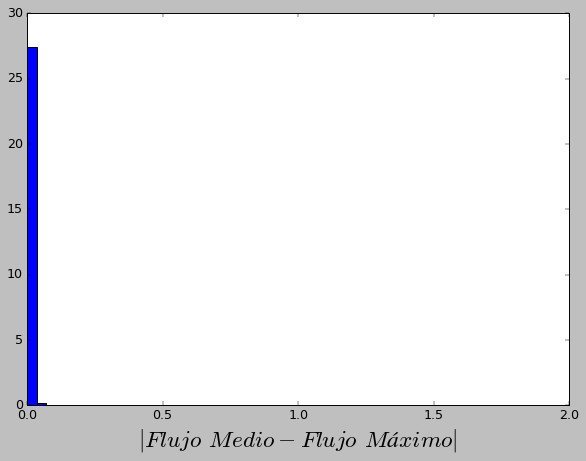

In [14]:
plt.figure(dpi=70,figsize=(10,7))
plt.hist(variable, bins = 'scott', edgecolor='k', density=1)
plt.xlabel('$|Flujo$ $Medio-Flujo$ $Máximo|$',fontsize = 24,fontweight='bold')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
#plt.xlim(-0.03,0.5)
#plt.savefig('Histogram_Flux.png',dpi=400)
plt.show()

Se toman los datos fotométricos multi-época de las estrellas que cumplen con la condición mencionada anteriormente.

In [8]:
star_almostvariable=[] #Estrellas que cumplen la condición
dataf=pd.DataFrame() #Se guardan los datos arrojados por gaia de las estrellas que cumplen la condición

for i in range(len(variable)):
    if variable[i]>np.mean(variable)+np.std(variable):
        star_almostvariable.append(df[i])
        dataf=dataf.append(results[results["index"]==np.array(results['index'])[i]])
        print(i)

0
429


## Se muestra de manera gráfica cuáles fueron las estrellas seleccionadas

Se hace un gráfico con las estrellas encontradas por el conesearch de gaia y las que les cambia el flujo de la estrella en buena medida

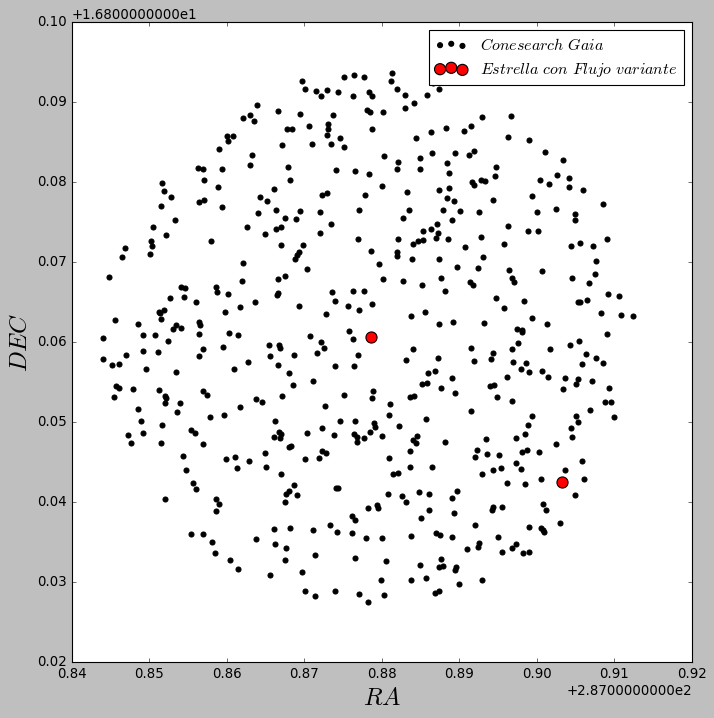

In [15]:
plt.figure(figsize=(10,10))
plt.scatter(results['ra'],results['dec'],c='k',label="$Conesearch$ $Gaia$")
plt.scatter(dataf['ra'],dataf['dec'],c='r',s=100,label="$Estrella$ $con$ $Flujo$ $variante$")
plt.xlabel("$RA$",fontsize=22)
plt.ylabel("$DEC$",fontsize=22)
plt.legend()
plt.savefig('Gráfica_Espacial.png',dpi=400)
plt.show()

Se puede identificar entonces que después de realizar este proceso se encuentran 2 estrellas con un cambio en el flujo relevante.

## Se procede a determinar la temperatura de las estrellas

Primero se calcula la distancia, luego la Magnitud Absoluta, posteriormente la luminosidad usando la ley de Pogson y finalmente la temperatura de la estrella con la ley de Stefan-Boltzmann

In [11]:
Lsol = 3.828e26 #W. Luminosidad del Sol
Msol = 5.45 #Magnitud del Sol en la banda G, sacado de Blanton et al.2003
Rwr124= 6.96e8*0.7 #0.7R⊙. Valor extraído de W.-R. Hamann, G. Gräfener, and A. Liermann.2006
sigma = 5.670373e-8 #W/m^2 K^4. Constante de Boltzmann

Mabsolute= lambda distance,m: m-5*np.log10(distance/10)
luminosidad = lambda Mabsolute: Lsol*10**((Msol-Mabsolute)/(2.5)) 
temperature = lambda luminosidad: (luminosidad/(4*np.pi*sigma*Rwr124**2))**(1/4)

M=Mabsolute(np.array(dataf['r_med_geo']),np.array(dataf["phot_g_mean_mag"]))
L=luminosidad(Mabsolute(np.array(dataf['r_med_geo']),np.array(dataf["phot_g_mean_mag"])))
T=temperature(luminosidad(Mabsolute(np.array(dataf['r_med_geo']),np.array(dataf["phot_g_mean_mag"]))))

print(f"La temperatura para la estrella del centro de la gráfica es {T[0]} K y la otra es de {T[1]} K.")

La temperatura para la estrella del centro de la gráfica es 48671.8125 K y la otra es de 7052.109375 K.


Como se puede observar, la estrella que está en el centro de la imagen tiene una temperatura de 4.87 x 10$^4$K cumpliendo con el rango de temperaturas para considerarse una estrella Wolf-Rayet. En efecto esta estrella es WR124.  

## Se calcula el periodo con el que cambia la luminosidad de las estrellas seleccionadas

Este periodo se calcula haciendo uso de la herramienta $\textit{LombScargle}$ de$\texttt{ gatspy.periodic}$

In [10]:
period=[]
power=[]
periodo=[]

for i in range(len(star_almostvariable)):
    mode=LombScargle().fit(star_almostvariable[i]["obsTime"],star_almostvariable[i]["psfFlux"],
                               star_almostvariable[i]["psfFluxErr"])
    period.append(mode.periodogram_auto(nyquist_factor=100)[0])
    power.append(mode.periodogram_auto(nyquist_factor=100)[1])
    periodo.append(period[i][np.argmax(power[i])])
print(f"El periodo para la estrella del centro de la gráfica es {periodo[0]} días \
y para la otra es de {periodo[1]} días")

El periodo para la estrella del centro de la gráfica es 2.5852196272058814 días y para la otra es de 4.160272280196628 días


## Se construye la curva de luz para WR124

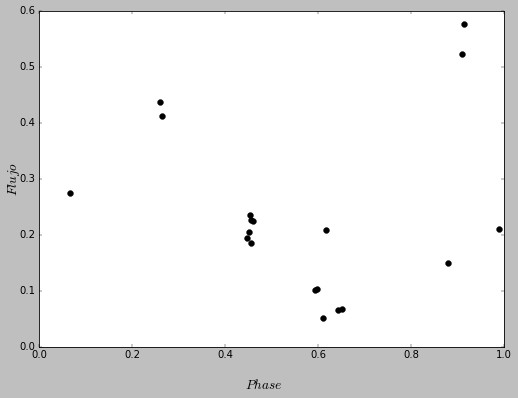

In [23]:
fig, axs = plt.subplots(1,1,figsize=(10,7),dpi=60,sharex=True,sharey=False)
fig.subplots_adjust(hspace=0,wspace=0)
magaper=lambda F:-2.5*np.log10(F)
errmagaper=lambda F,dF:-2.5*(dF/F)
k=0         
phase = (star_almostvariable[k]['obsTime']/periodo[k])%1
axs.errorbar(phase,star_almostvariable[k].psfFlux,
             yerr=star_almostvariable[k].psfFluxErr,
             fmt="ko",markersize=7)
    
fig.text(0.5, 0, '$Phase$', ha='center',fontsize = 16)
fig.text(0.07, 0.5, '$Flujo$', va='center', rotation='vertical',fontsize = 16)
plt.savefig("CurvaLuz_WR124",dpi=400)
plt.show()        